# Background-Processing 

**Goal:** I wanted to have *faster* turn around code for running over the data MNTs.

I've tried to *vectorize* the processing, but since some of the MNTs are *so large*, I'm *not* sure if I'll be able to load it all into memory at once, or if I can use Mason's function to load just a *part* of the TTree.


**Note from Jim @ pyhep:** Whenever you're having *memory issues*, iterate over the tree in batches.
- This is what Sean is doing rn for his reweighting production
- For data, I *don't* need the whole file at once b/c I don't need to derive the scale and shift networks for the ML preprocessing b/c those are derived on signal.
- The only thing is that to "pseudo-tag" the 2b events, I'll need to have *already made* the pseudo-tag maps.
- So, I'll either have to *re-run* over 2b, or get Mason's TTree selector github working!!

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from itertools import combinations
from glob import glob
from tqdm import tqdm

from trainNet import pairAGraph
from preprocess import applyCuts

import uproot
from uproot_methods.classes.TLorentzVector import TLorentzVectorArray
from uproot_methods.classes.TVector3 import TVector3Array

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

import os
os.sys.path.append('../code')
from analysis import getXwt, getXhh, triggers
from analysis import triggers

os.sys.path.append('../eda_tools')
from plot_helper import massplane

from preprocess import processDf, transformData, pairAndProcess

%load_ext autoreload
%autoreload 2

## Step 1: Preprocessing

In [23]:
# Open the MTN
filename = f'../../public/hh4b/data/user.mswiatlo.HH4B.periodA.data16..AB21.2.91-FEB20-0.pflow_vr_MiniNTuple.root/user.mswiatlo.20664130._000001.MiniNTuple.root'

treename = "XhhMiniNtuple" 
f = uproot.open(filename)
tree = f[treename]

In [27]:
tree.pandas.df(flatten=False)

runNumber  eventNumber  lumiBlock  coreFlags  bcid  NPV  \
entry                                                            
0         297730      1103322        109          0  3123   17   
1         297730      1144216        109          0   440   15   
2         297730      1055229        109          0  1340   15   
3         297730      1611302        109          0  3119   14   
4         297730      1540331        109          0  3123   15   
...          ...          ...        ...        ...   ...  ...   
25824     297730    324210948        515          0  1343    9   
25825     297730    324058403        515          0   445    9   
25826     297730    324156563        515          0  2238   13   
25827     297730    323993224        515          0   442    9   
25828     297730    324088368        515          0  2239   10   

       actualInteractionsPerCrossing  averageInteractionsPerCrossing  \
entry                                                                  
0                          29.845642                       26.974831   
1                          24.658413                       26.974831   
2                          26.602964                       26.974831   
3                          24.756943                       26.974831   
4                          29.845642                       26.974831   
...                              ...                             ...   
25824                      20.574705                       20.641485   
25825                      21.512327                       20.641485   
25826                      20.510633                       20.641485   
25827                      19.642303                       20.641485   
25828                      20.132847                       20.641485   

       weight_pileup  correctedAverageMu  ...  boostedJets_ntrk1000  \
entry                                     ...                         
0                1.0                -1.0  ...                    []   
1                1.0                -1.0  ...                    []   
2                1.0                -1.0  ...                    []   
3                1.0                -1.0  ...                    []   
4                1.0                -1.0  ...          [31.0, 16.0]   
...              ...                 ...  ...                   ...   
25824            1.0                -1.0  ...                    []   
25825            1.0                -1.0  ...                [22.0]   
25826            1.0                -1.0  ...                    []   
25827            1.0                -1.0  ...                    []   
25828            1.0                -1.0  ...                    []   

        boostedJets_trkwidth500  boostedJets_trkwidth1000  \
entry                                                       
0                            []                        []   
1                            []                        []   
2                            []                        []   
3                            []                        []   
4      [0.12151996, 0.21377923]  [0.12059191, 0.20118329]   
...                         ...                       ...   
25824                        []                        []   
25825              [0.29134524]              [0.29082742]   
25826                        []                        []   
25827                        []                        []   
25828                        []                        []   

      jet_ak2track_asso_fatjet  boosted_bevent_sys  \
entry                                                
0                           []                  []   
1                           []                  []   
2                           []                  []   
3                           []                  []   
4              [0, 0, 1, 1, 1]                  []   
...                        ...                 ...   
25824                       []                  []   
25825  

In [3]:
tree['runNumber']

<TBranch b'runNumber' at 0x7f1c677dadd0>

In [4]:
tree['eventNumber']

<TBranch b'eventNumber' at 0x7f1c677dae90>

In [5]:
parts = filename.split('.')

periodTag = parts[7]
fileNumTag = parts[-3]

dataSample = parts[8]
dataProdTag = filename.split('-')[1]

In [6]:
periodTag, fileNumTag, dataSample, dataProdTag

('periodA', '_000001', 'data16', 'FEB20')

In [7]:
#mc = '../../public/hh4b/SMNR/user.jagrundy.HH4B.450000.SM_HH.MC16e-2018.AB21.2.91-MAR20-0.full_MiniNTuple.root/user.jagrundy.20736225._000002.MiniNTuple.root'
mc = '../../public/hh4b/SMNR/user.jagrundy.HH4B.450000.SM_HH.MC16d-2017.AB21.2.91-MAR20-0.full_MiniNTuple.root/user.jagrundy.20736216._000001.MiniNTuple.root'

f = uproot.open(mc)
tree1 = f[treename]
tree1.numentries

973303

In [8]:
tree1[b'eventNumber'].numbaskets

2002

**What's the maximum # of events in *any* of these files?**

In [9]:
periods = ['A','B','C','D','E','F','G','H','I','J','K','L']
evts = {p:[] for p in periods}

files = f'../../public/hh4b/data/user.mswiatlo.HH4B.period*.data16..AB21.2.91-FEB20-0.pflow_vr_MiniNTuple.root/user.mswiatlo.20664130._00*.MiniNTuple.root'

nFiles = 0
for period in periods:

    nFiles += len(glob(files))
    for fi in glob(files):
        t = uproot.open(fi)[treename]
        
        evts[period].append(t.numentries)
        
    print(period,max(evts[period]))
print('# files',nFiles)

A 731154
B 731154
C 731154
D 731154
E 731154
F 731154
G 731154
H 731154
I 731154
J 731154
K 731154
L 731154
# files 240


## Step 2: Model evaluation

I ende up implementing this in `prepareData`.


## Step 3: The rest of the cuts

In [10]:
reload = False

In [11]:
filename_3b = '../data/data16_PFlow-FEB20-5jets/df_last_hp_3b.h5'

if reload:
    dfs = []
    for f in tqdm(glob('../data/data16_PFlow-FEB20-5jets/files/df_period?_*_last_hp_3b.h5')):
        dfi = pd.read_hdf(f,key='df')
        dfs.append(dfi)

    df = pd.concat(dfs)
    
    df.to_hdf(filename_3b,key='df')
    
else:
    df = pd.read_hdf(filename_3b,key='df')
    

SR center: (120.0,110.0) GeV


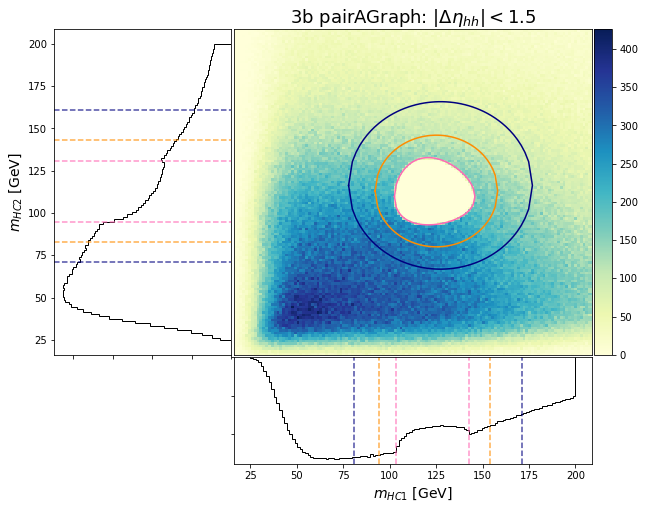

In [12]:
kwargs = {'figsize': (10, 8),
           'bins' : (125, 125),
           'xrange': (25, 200),
           'yrange': (25, 200),
           'xhisttype': 'step',
           'yhisttype': 'step',
           'cmap': 'YlGnBu',
           'title': '3b pairAGraph: $|\Delta \eta_{hh}| < 1.5$',
           'xlabel': '$m_{HC1}$ [GeV]',
           'ylabel': '$m_{HC2}$ [GeV]',
           'axis_hist_on': True,
           'hist_color': 'black',
           #'filename': f'{figDir}/massplane_4jetsGNN_2b.pdf',
           'alpha': 0.7,
           'save': False,
           'show': True
          }

mask = (df.ntag==3) & (np.abs(df.eta_h1-df.eta_h2) < 1.5) & (df.kinematic_region != 0) 
fig = massplane(df.loc[mask,'m_h1'],
                df.loc[mask,'m_h2'],**kwargs)

SR center: (120.0,110.0) GeV


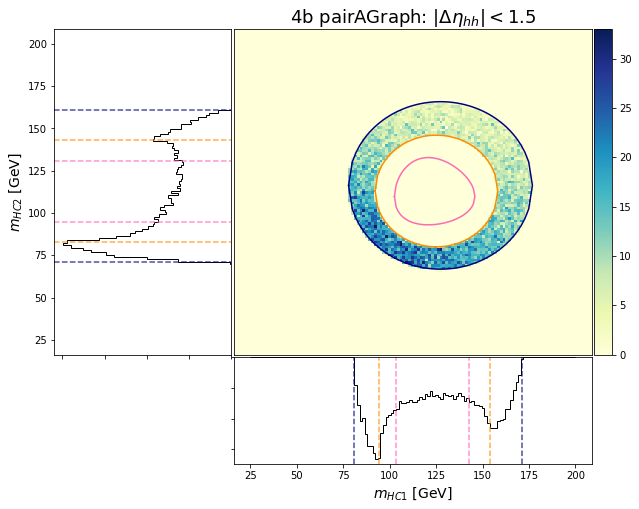

In [13]:
kwargs['title'] = '4b pairAGraph: $|\Delta \eta_{hh}| < 1.5$'
mask = (df.ntag>=4) & (np.abs(df.eta_h1-df.eta_h2) < 1.5) & (df.kinematic_region == 2) 
fig = massplane(df.loc[mask,'m_h1'],
                df.loc[mask,'m_h2'],**kwargs)

In [14]:
np.sum((df.ntag>=4) & (np.abs(df.eta_h1-df.eta_h2) < 1.5) & (df.kinematic_region == 2) )

21553

In [15]:
for ntag, mask in zip([3,4],[df.ntag==3,df.ntag>=4]):
    for r,region in zip([1,2],['VR','CR']):
        
        print(f'{ntag}b {region}:',np.sum(mask&(df.kinematic_region==r) & (np.abs(df.eta_h1-df.eta_h2) < 1.5)))

3b VR: 165606
3b CR: 296218
4b VR: 11729
4b CR: 21553


C.f. my b-tagging #s, this is *comparable* in the CR and lower in the VR, a product of *less sculpting*.

SR center: (120.0,110.0) GeV


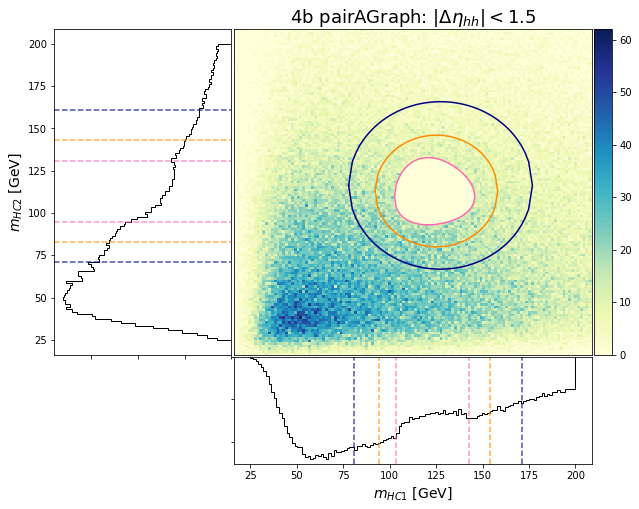

In [16]:
kwargs['title'] = '4b pairAGraph: $|\Delta \eta_{hh}| < 1.5$'
mask = (df.ntag>=4) & (np.abs(df.eta_h1-df.eta_h2) < 1.5) & (df.kinematic_region != 0) 
fig = massplane(df.loc[mask,'m_h1'],
                df.loc[mask,'m_h2'],**kwargs)

Does Sean have these numbers in the note??

In [17]:
filename_2b = '../data/data16_PFlow-FEB20-5jets/df_last_hp_2b.h5'

if reload:
    dfs = []
    for f in tqdm(glob('../data/data16_PFlow-FEB20-5jets/files/df_period?_*_last_hp_2b.h5')):
        #print(f)
        dfi = pd.read_hdf(f,key='df')
        dfs.append(dfi)

    df_2b = pd.concat(dfs)
    
    df_2b.to_hdf(filename_2b,key='df')
else:
    df_2b = pd.read_hdf(filename_2b,key='df')

SR center: (120.0,110.0) GeV


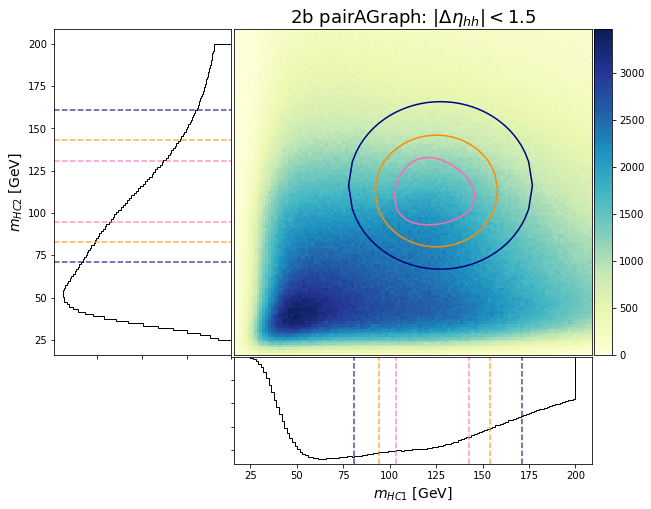

In [18]:
kwargs['title'] = '2b pairAGraph: $|\Delta \eta_{hh}| < 1.5$'
mask = np.abs(df_2b.eta_h1-df_2b.eta_h2) < 1.5
fig = massplane(df_2b.loc[mask,'m_h1'],
                df_2b.loc[mask,'m_h2'],**kwargs)

SR center: (120.0,110.0) GeV


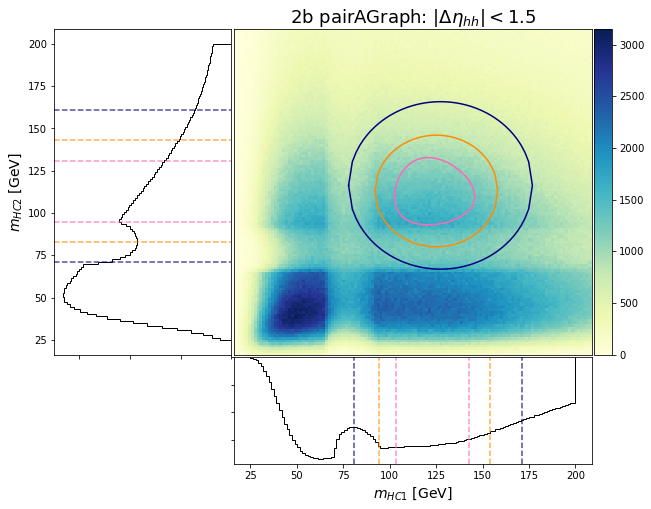

In [19]:
mask = (np.abs(df_2b.eta_h1-df_2b.eta_h2) < 1.5) & (df_2b.X_wt > 1.5)
fig = massplane(df_2b.loc[mask,'m_h1'],
                df_2b.loc[mask,'m_h2'],**kwargs)

In [20]:
df_2b['abs_deta_hh'] = np.abs(df_2b.eta_h1-df_2b.eta_h2)

In [21]:
df_2b.columns

Index(['run_number', 'event_number', 'mc_sf', 'ntag', 'njets',
       'kinematic_region', 'm_hh', 'pt_hh', 'X_wt', 'm_hh_cor', 'pT_h1',
       'eta_h1', 'phi_h1', 'm_h1', 'dRjj_h1', 'pT_h2', 'eta_h2', 'phi_h2',
       'm_h2', 'dRjj_h2', 'pT_2', 'pT_4', 'eta_i', 'dRjj_1', 'dRjj_2',
       'cosThetaStar', 'cosTheta1', 'cosTheta2', 'Phi', 'Phi1', 'ml_j0_Db',
       'ml_j1_Db', 'ml_j2_Db', 'ml_j3_Db', 'ml_j4_Db', 'HT', 'MDR', 'MDpT',
       'abs_deta_hh'],
      dtype='object')

In [22]:
norm = np.sum((df.kinematic_region==2) & (df.ntag>=4)) / np.sum(df_2b.kinematic_region==2) 

SR_2b = (df_2b.X_wt > 1.5) & (df_2b.kinematic_region==0) & (df_2b['abs_deta_hh'] < 1.5)
n_2b = np.sum(SR_2b)

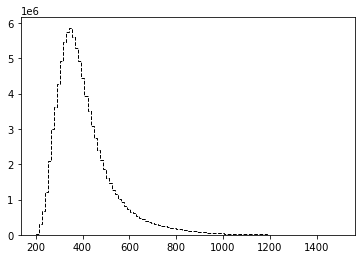

In [34]:
plt.hist(df_2b.loc[SR_2b,'m_hh'],100,(200,1500),weights=np.ones(n_2b)/norm,
         color='k',histtype='step',linestyle='--')
plt.show()

In [35]:
np.sum(SR_2b) / np.sum((df_2b.kinematic_region==0) & (df_2b['abs_deta_hh'] < 1.5))

0.8174391055559509

Interesting, this seems like a *much* bigger impact of QCD on $X_{wt}$ *now* than it was before, I wonder why that might be?

I could maybe get a $\kappa_\lambda$ limit *right away* from here since the events aren't dying off at low $m_{hh}$


Hmmmm, these are still v high background counts though, I should at least investigate if the MDR and $p_T^{h,i}$ cuts help


In [36]:
physicsSample = 'SMNR'
nSelectedJets = 5
prodTag = 'MAR2020'

In [37]:
with open(f"configs/last_hp.json", 'r') as varfile:
    GNNParams = json.load(varfile)
nLayers, embed_dim, ff_dim = GNNParams['nLayers'], GNNParams['embed_dim'], GNNParams['ff_dim']
nHeads, dpt, lr, epoch = GNNParams['nHeads'], GNNParams['dpt'], GNNParams['lr'], GNNParams['epoch']

In [38]:
model = pairAGraph(inpt_dim=5,embed_dim=embed_dim,ff_dim=ff_dim,
                   nAttnBlocks=1,nHeads=nHeads,p=dpt,njets=nSelectedJets)

# Load in the weights from a previously trained model
xformerDir = f'xformer_{nLayers}layers_dim{embed_dim}_ff{ff_dim}_{nHeads}heads_dpt{dpt}_jetCompatibility_lr{lr}_batch2048_mask'
modelDir = f"models/{physicsSample}_mc16ade_PFlow-{prodTag}-{nSelectedJets}jets/{xformerDir}"

model.load_state_dict(torch.load(f'{modelDir}/model.pt',map_location='cpu'))
model.eval()

pairAGraph(
  (toLatent): Linear(in_features=5, out_features=20, bias=True)
  (encoderLayer1): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): Linear(in_features=20, out_features=20, bias=True)
    )
    (linear1): Linear(in_features=20, out_features=20, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (linear2): Linear(in_features=20, out_features=20, bias=True)
    (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.3, inplace=False)
    (dropout2): Dropout(p=0.3, inplace=False)
  )
  (finalAttnLayer): MultiheadAttention(
    (out_proj): Linear(in_features=20, out_features=20, bias=True)
  )
)

Let's just try to get an $s/\sqrt{b}$ number!

In [39]:
from analysis import normalizeWeight

In [40]:
subDir = f'{physicsSample}_mc16a_PFlow-{prodTag}-{nSelectedJets}jets'
sdf = pd.read_hdf(f"../data/{subDir}/df_3b_scaledInputs.h5", key='df')
sdf = sdf[sdf.index % 2 == 0]

# Since I'm only using half the stats for the test set, need to multiply L by 2.
key = f'{physicsSample}_mc16a_PFlow-{prodTag}'
print(key)
L = 24.5556
normalizeWeight(sdf,key,lumi=L*2)

SMNR_mc16a_PFlow-MAR2020
/u/ki/nhartman/gpfs/public/hh4b/SMNR/user.jagrundy.HH4B.450000.SM_HH.MC16a-2015-2016.AB21.2.91-MAR20-0.full_MiniNTuple.root/user.jagrundy.20736236._000001.MiniNTuple.root
sum_weights_initial 26458.62742272562
xsec 27.47
k_factor 1.13
gen_filter_eff 0.3392
sample_weight 0.019543672735207792


In [41]:
applyCuts(sdf,model,nSelectedJets)

max(njets) 5
Getting jet pts
Getting jet etas
Getting jet phis
Getting jet Es
Calculating Xwt
Calculating Xhh


In [42]:
sdf['abs_deta_hh'] = np.abs(sdf.eta_h1 - sdf.eta_h2)

In [43]:
edges = np.array([150, 250, 262, 275, 288, 302, 317, 332, 348, 365, 383, 402, 422, 443, 465, 488, 512, 
                  537, 563, 591, 620, 651, 683, 717, 752, 789, 828, 869, 912, 957,1004, 1054, 1106, 1161, 
                  1219, 1279, 1342, 1409, 1479, 1552, 1629, 1710, 1795, 1884, 1978, 2076])

In [44]:
norm

0.008366370461331629

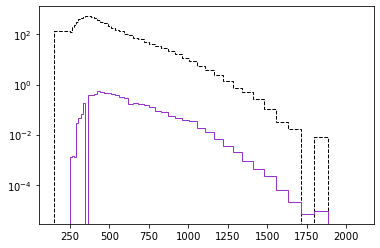

In [45]:
b,_,_ = plt.hist(df_2b.loc[SR_2b,'m_hh'],edges,
                 weights=np.ones(n_2b)*norm,log=True,
                 color='k',histtype='step',linestyle='--')

smask = (sdf.ntag>=4)&(sdf.trigger) & (sdf.abs_deta_hh < 1.5) 
smask = smask & (sdf.X_wt > 1.5) & (sdf.kinematic_region == 0)
s,e,_ = plt.hist(sdf.loc[smask,'m_hh'],edges,
                 weights=sdf.loc[smask,'mc_sf'],
         color='darkorchid',histtype='step',log=True)

plt.show()

SR center: (120.0,110.0) GeV


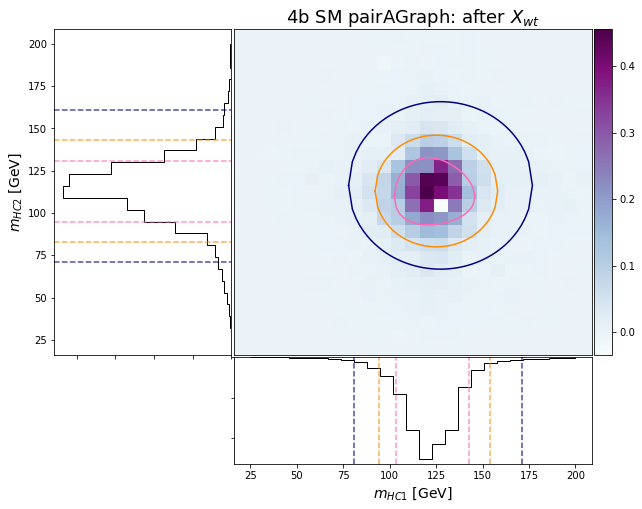

In [46]:
kwargs = {'figsize': (10, 8),
           'bins' : (25, 25),
           'xrange': (25, 200),
           'yrange': (25, 200),
           'xhisttype': 'step',
           'yhisttype': 'step',
           'cmap': 'BuPu',
           'title': '4b SM pairAGraph: after $X_{wt}$',
           'xlabel': '$m_{HC1}$ [GeV]',
           'ylabel': '$m_{HC2}$ [GeV]',
           'axis_hist_on': True,
           'hist_color': 'black',
           #'filename': f'{figDir}/massplane_4jetsGNN_2b.pdf',
           'alpha': 0.7,
           'save': False,
           'show': True
          }

smask0 = (sdf.ntag>=4)&(sdf.trigger) & (sdf.abs_deta_hh < 1.5) & (sdf.X_wt > 1.5)
kwargs['weights'] = sdf.loc[smask0,'mc_sf']
fig = massplane(sdf.loc[smask0,'m_h1'],
                sdf.loc[smask0,'m_h2'],**kwargs)

In [47]:
sdf['m_h1b'] = np.where(sdf['pT_h1'] > sdf['pT_h2'], sdf['m_h1'], sdf['m_h2'])
sdf['m_h2b'] = np.where(sdf['pT_h1'] < sdf['pT_h2'], sdf['m_h1'], sdf['m_h2'])

SR center: (120.0,110.0) GeV


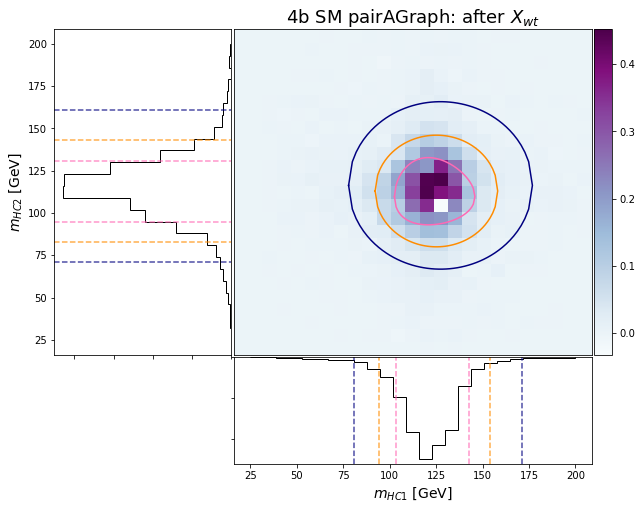

In [48]:
fig = massplane(sdf.loc[smask0,'m_h1b'],
                sdf.loc[smask0,'m_h2b'],**kwargs)

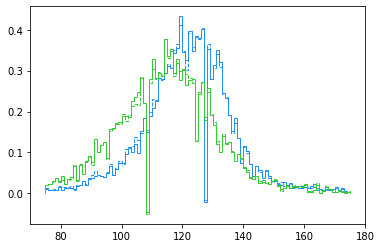

In [49]:
plt.hist(sdf.loc[smask0,'m_h1'],100,(75,175),weights=sdf.loc[smask0,'mc_sf'],
         histtype='step',color='dodgerblue')
plt.hist(sdf.loc[smask0,'m_h1b'],100,(75,175),weights=sdf.loc[smask0,'mc_sf'],
         histtype='step',color='dodgerblue',linestyle='--')

plt.hist(sdf.loc[smask0,'m_h2'],100,(75,175),weights=sdf.loc[smask0,'mc_sf'],
         histtype='step',color='limegreen')
plt.hist(sdf.loc[smask0,'m_h2b'],100,(75,175),weights=sdf.loc[smask0,'mc_sf'],
         histtype='step',color='limegreen',linestyle='--')
plt.show()

Wow - there's almost *no* difference b/w the HC orderings, this is *soooo* wierd, and different from before... *why*??

SR center: (120.0,110.0) GeV


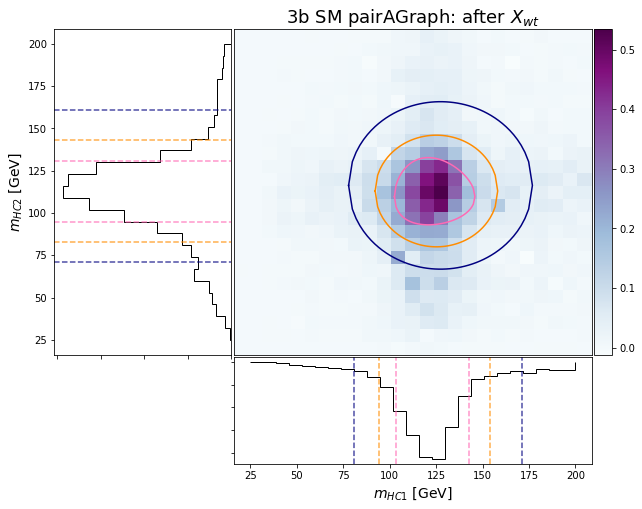

In [50]:
kwargs['title'] = '3b SM pairAGraph: after $X_{wt}$'

smask1 = (sdf.ntag==3) & (sdf.trigger) & (sdf.abs_deta_hh < 1.5) & (sdf.X_wt > 1.5)
kwargs['weights'] = sdf.loc[smask1,'mc_sf']
fig = massplane(sdf.loc[smask1,'m_h1'],
                sdf.loc[smask1,'m_h2'],**kwargs)

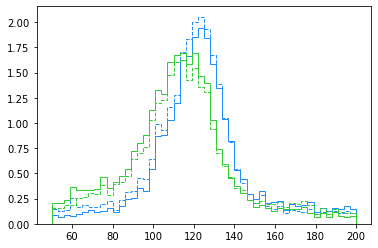

In [51]:
n1,_,_  = plt.hist(sdf.loc[smask1,'m_h1'],50,(50,200),weights=sdf.loc[smask1,'mc_sf'],
                   histtype='step',color='dodgerblue')
n1b,_,_ = plt.hist(sdf.loc[smask1,'m_h1b'],50,(50,200),weights=sdf.loc[smask1,'mc_sf'],
                   histtype='step',color='dodgerblue',linestyle='--')

n2,_,_  = plt.hist(sdf.loc[smask1,'m_h2'],50,(50,200),weights=sdf.loc[smask1,'mc_sf'],
                   histtype='step',color='limegreen')
n2b,_,_ = plt.hist(sdf.loc[smask1,'m_h2b'],50,(50,200),weights=sdf.loc[smask1,'mc_sf'],
                   histtype='step',color='limegreen',linestyle='--')

plt.show()

I think the dashed line looks *slightly* better - no?


In [52]:
np.sum(n1),np.sum(n1b)

(25.24899846413909, 26.809696195109904)

In [53]:
np.sum(n2),np.sum(n2b)

(27.704405249563713, 26.143707518592894)

Yes - they are!

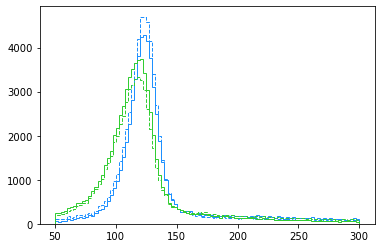

In [54]:
n1,_,_  = plt.hist(sdf.loc[smask1,'m_h1'],100,(50,300),histtype='step',color='dodgerblue')
n1b,_,_ = plt.hist(sdf.loc[smask1,'m_h1b'],100,(50,300),histtype='step',color='dodgerblue',linestyle='--')

n2,_,_  = plt.hist(sdf.loc[smask1,'m_h2'],100,(50,300),histtype='step',color='limegreen')
n2b,_,_ = plt.hist(sdf.loc[smask1,'m_h2b'],100,(50,300),histtype='step',color='limegreen',linestyle='--')

plt.show()

In [55]:
np.sum(n1),np.sum(n1b)

(60412.0, 64119.0)

In [56]:
np.sum(n2),np.sum(n2b)

(67219.0, 63512.0)

**Awesome:** So *now* it seems really clear where to put in effort - actually *decreasing* the size of the SR.

**Plan:**
- Put the mean of $X_{hh}$ in the *center* of the SR

In [57]:
mmin, mmax = 126-45,126+45
fit_mask = smask0 & (sdf.m_h1 > mmin) & (sdf.m_h1 < mmax) 
mmin, mmax = 116-45,116+45
fit_mask = fit_mask& (sdf.m_h2 > mmin) & (sdf.m_h2 < mmax)

c1 = np.average(sdf.loc[fit_mask,'m_h1'],weights=sdf.loc[fit_mask,'mc_sf'])
c2 = np.average(sdf.loc[fit_mask,'m_h2'],weights=sdf.loc[fit_mask,'mc_sf'])

c1,c2

(121.98720848814149, 114.28375801530163)

Awesome - let's *replot* with the new centers

SR center: (122.0,114.3) GeV


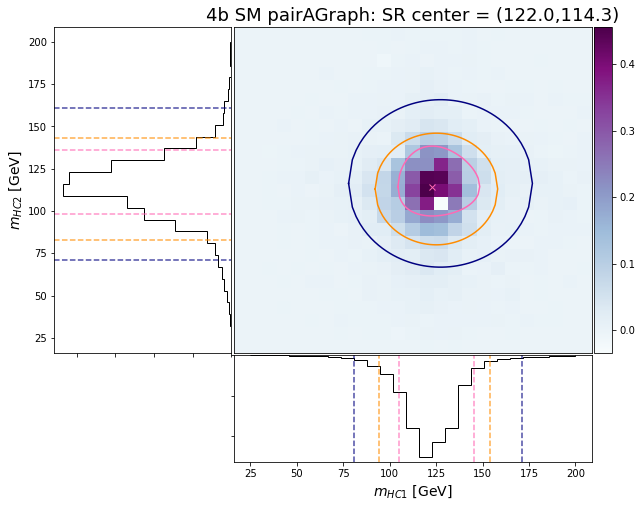

In [58]:
kwargs['title'] = f'4b SM pairAGraph: SR center = ({c1:.1f},{c2:.1f})'
kwargs['SR_center'] = (c1,c2)
kwargs['plot_center'] = True

smask0 = (sdf.ntag>=4)&(sdf.trigger) & (sdf.abs_deta_hh < 1.5) & (sdf.X_wt > 1.5)
kwargs['weights'] = sdf.loc[smask0,'mc_sf']
fig = massplane(sdf.loc[smask0,'m_h1'],
                sdf.loc[smask0,'m_h2'],**kwargs)

It's really clear that I want *separate* resolutions in the x,y directions though.

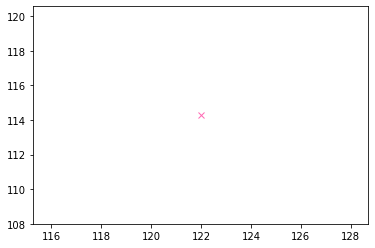

In [59]:
plt.plot([c1],[c2],marker='x',color='hotpink')

In [60]:
np.sum(s)

6.080092678842984

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


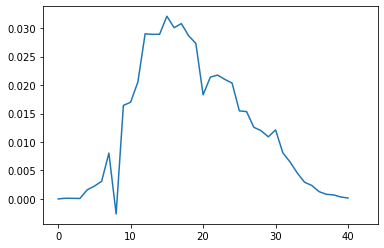

In [61]:
plt.plot(s/np.sqrt(b))

In [62]:
np.sqrt(np.sum(s[b!=0]**2/b[b!=0]))

0.10650523952360669